In [1]:
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>') 

In [11]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from local_dotplot_lib import *

trna= "GCCUUUUUAGCUCAGUGGUAGAGCAUUGUAUUUUUGUAAUGCGGUGGUCGUCGGUUCGAAUCCGACAAAAGGCU"
trna2="GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA"

bpmat = getBPPM(trna)
bpmat

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.996,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ..., 
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ]])

In [61]:
bpmat.shape

(74, 74)

In [4]:
np.set_printoptions(suppress=True,precision=3)
bpmat = getBPPM('GCGUGCUGCGC')
print bpmat

[[ 0.     0.     0.     0.     0.     0.     0.     0.     0.106  0.     0.855]
 [ 0.     0.     0.     0.     0.     0.     0.     0.106  0.     0.875  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.04   0.     0.873  0.     0.002]
 [ 0.     0.     0.     0.     0.     0.     0.     0.764  0.     0.002  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.002  0.     0.001]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.001  0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]


In [110]:
def walk_basepairs_get_stems(mat, p_thresh=0.5):
    bpXs, bpYs = np.where(mat > p_thresh) # Note: hopefully the returned  indices of where are sorted by x values
    bpXs +=1
    bpYs += 1 
    if len(bpXs) == 0:
        print ("WARNING: No basepair with prob larger than {}".format(p_thresh))
        return {}
        
    # startX: 3'end startY:5'end of the stem
    stem_startX, stem_startY = bpXs[0], bpYs[0]
    stem_endX, stem_endY = bpXs[0], bpYs[0]
    stems_dict = {} 
    stems_list = []
    for x, y in zip(bpXs, bpYs):
        #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)

        #print x,y,
        if ( (abs(x-stem_endX) <= 1) or (abs(y-stem_endY) <= 1)
               and (abs(x-stem_endX) <= 5) and (abs(y-stem_endY) <= 5) ):
            
#             if (abs(x-stem_endX) >= 5) or (abs(y-stem_endY) >= 5):
#                 print "WARNING: bulge of size larger than 5 added at x={}, y={}! ".format(x,y)
                
            stem_endX = x
            stem_endY = y
        else:
            #print " new",
            #print '  {}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # Validating order of stem indices
            
            assert stem_startX <= stem_endX
            assert stem_endX < stem_endY
            assert stem_endY <= stem_startY
            
            # stem coords as key string
            k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
            # stem length as dict value
            stems_dict[k] = max( (stem_endX-stem_startX) , (stem_startY-stem_endY)), stem_endY-stem_endX
            
            stem_startX, stem_startY = x, y
            stem_endX, stem_endY = x, y
    
    k = '{}-{},{}-{}'.format(stem_startX,stem_endX, stem_endY, stem_startY)
    #print k, stem_endX-stem_startX , (stem_startY-stem_endY)
    assert k not in stems_dict # It should be the case always..?
    stems_dict[k] = max( (stem_endX-stem_startX+1) , (stem_startY-stem_endY+1)), stem_endY-stem_endX 
    
    return stems_dict
    
walk_basepairs_get_stems(bpmat)
# bpXs, bpYs = np.where(bpmat>0.5)
# zip(bpXs, bpYs, bpXs+1, bpYs+1)


{'1-7,67-73': (6, 60),
 '21-22,48-49': (1, 26),
 '24-32,38-46': (8, 6),
 '50-54,62-66': (5, 8)}

In [132]:
def average_basepair_prob_seqs(seq_arr):
    seq_lengths = [len(s) for s in seq_arr]
    if len(set(seq_lengths)) != 1:
        raise RuntimeError ("Input sequences must have same lenghts found set of lengths:\t{}".format(set(seq_lengths)))
    bpmat_arr = [ getBPPM(s) for s in seq_arr]
    return np.average(bpmat_arr, axis=0)

def walk_stem_seqs(seq_arr):
    seq_lengths = [len(s) for s in seq_arr]
    if len(set(seq_lengths)) != 1:
        raise RuntimeError ("Input sequences must have same lenghts found set of lengths:\t{}".format(set(seq_lengths)))
    stems_dic_arr = [ walk_basepairs_get_stems(mat=getBPPM(s)) for s in seq_arr]
    return stems_dic_arr

from Bio import SeqIO
def analyze_fasta_set(fasta_file,average=True, walk_stems=False, shuffle=False):
    seqs = [str(s.seq) for s in SeqIO.parse(fasta_file, format='fasta')] 
    if shuffle is True:
        seqs = [dinuclShuffle(s.upper().replace('T','U')) for s in seqs]
        fig_file = fasta_file.replace('fasta','fa').replace('.fa','.shuffled.dp')
    else:
        fig_file = fasta_file.replace('fasta','fa').replace('.fa','.dp')
    
    if average:
        plot_heat_maps(None, average_basepair_prob_seqs(seqs), filename=fig_file, what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
    if walk_stems:
        return walk_stem_seqs(seqs)
def filter_stemsd_list(sdl, max_inner_distance=10, min_stem_length=4):
    sdl_filt = list()
    for sd in sdl:
        #print sd
        sd_filt ={k:sd[k] for k in sd if sd[k][0]>=min_stem_length and sd[k][1]<=max_inner_distance}
        #print sd_filt
        #print
        sdl_filt.append(sd_filt)
    return sdl_filt

stemsdic_list =    analyze_fasta_set('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta'
                   ,walk_stems=True, average=False)
    

In [171]:
stemsdic_list_shuff =     analyze_fasta_set('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta'
                   ,walk_stems=True, average=False,shuffle=True)
    

In [138]:
print len(stemsdic_list), len(stemsdic_list_shuff)
print (len([s for s in filter_stemsd_list(stemsdic_list,20,7) if len(s)>0]),
       len([s for s in filter_stemsd_list(stemsdic_list_shuff,20,7) if len(s)>0])
      )

1700 1700
(775, 708)


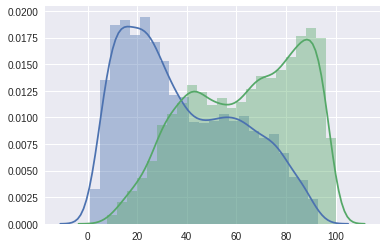

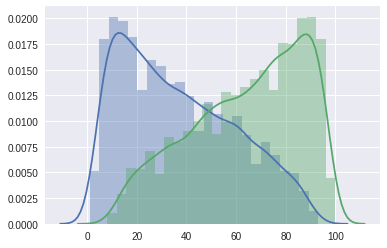

In [168]:
%matplotlib inline
from matplotlib import pyplot as plt
import re
import seaborn as sns
def plot_stems_loc(stemdl):
    starts = [ int(re.split("\D+", k)[1]) for sd in stemdl for k in sd  if len(sd)>0 ]
    sns.distplot(starts)
    ends = [ int(re.split("\D+", k)[2]) for sd in stemdl for k in sd  if len(sd)>0 ]
    sns.distplot(ends)
plot_stems_loc(stemsdic_list)
plt.show()
plot_stems_loc(stemsdic_list_shuff)
plt.show()

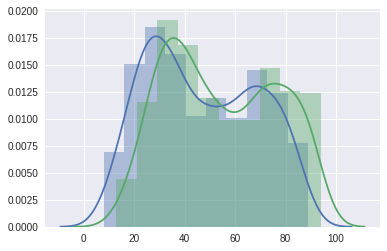

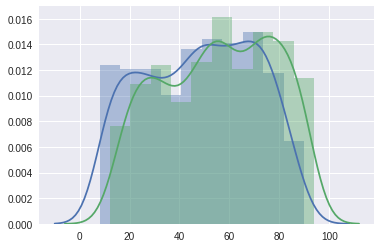

In [170]:
plot_stems_loc(filter_stemsd_list(stemsdic_list,15,7))
plt.show()
plot_stems_loc(filter_stemsd_list(stemsdic_list_shuff,15,7))

In [167]:
filter_stemsd_list(stemsdic_list,10,7)

[{},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {'3-13,23-31': (10, 10)},
 {},
 {},
 {},
 {},
 {'33-41,46-53': (9, 5)},
 {'56-66,75-85': (11, 9)},
 {},
 {'1-13,22-35': (13, 9)},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {},
 {'22-32,39-48': (11, 7)},
 {'27-34,39-47': (8, 5)},
 {},
 {},
 {},
 {},
 {},
 {},
 {'10-20,24-35': (11, 4)},
 {'13-28,35-49': (15, 7)},
 {},
 {'77-84,90-99': (10, 6)},
 {},
 {},
 {},
 {},
 {'64-78,84-100': (17, 6)},
 {},
 {},
 {'75-81,87-93': (7, 6)},
 {},
 {'47-53,60-66': (7, 7)},
 {'9-17,24-34': (10, 7)},
 {},
 {},
 {'43-54,59-89': (30, 5)},
 {},
 {},
 {},
 {},
 {},
 {},
 {'34-43,48-55': (10, 5)},
 {},
 {},
 {},
 {'22-34,39-51': (13, 5)},
 {},
 {},
 {'67-74,81-88': (8, 7)},
 {},
 {},
 {'1-8,13-19': (7, 5)},
 {},
 {},
 {},
 {'24-33,38-47': (9, 5)},
 {'10-25,31-41': (15, 6)},
 {},
 {},
 {'34-42,47-54': (8, 5)},
 {},
 {},
 {'31-41,47-57': (10, 6)},
 {},
 {},
 {'46-55,64-74': (11, 9)},
 {'14-30,35-92': (57, 5), '53-65,72-82': (13, 7)},

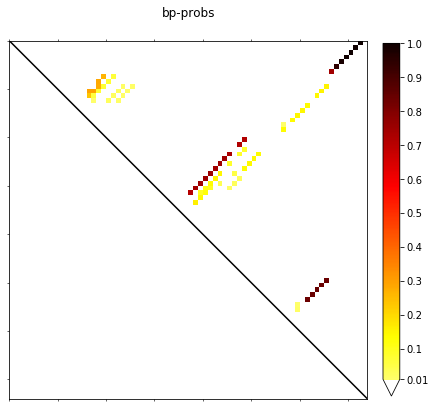

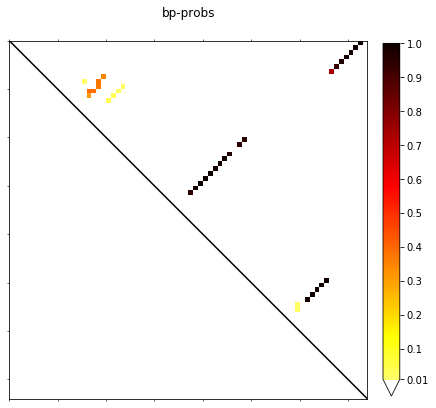

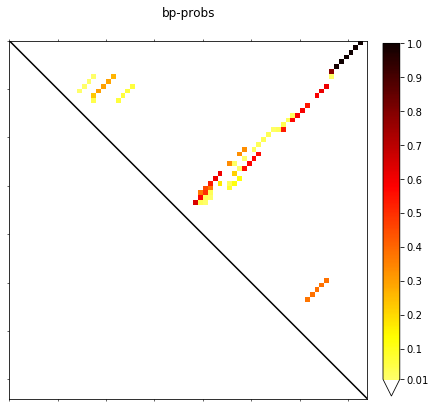

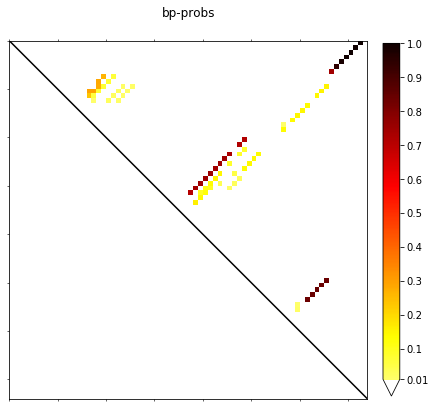

In [81]:
plot_heat_maps(None, getBPPM(trna), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)
plot_heat_maps(None, getBPPM(trna2), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)

plot_heat_maps(None, average_basepair_prob_seqs([trna,trna2,trna,trna]), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=True, interactive=False, gene_loc=None)   

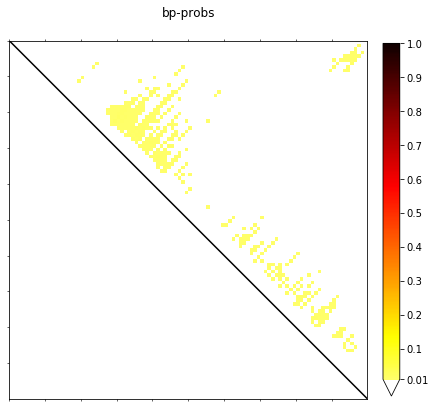

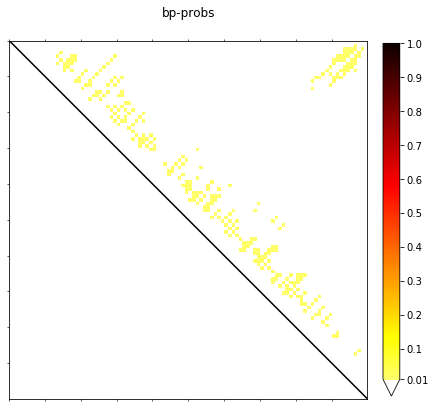

In [8]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta')
<
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-phastcons0.2-mergedoverlaps-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)

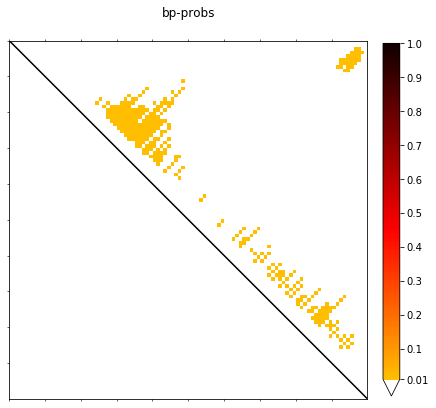

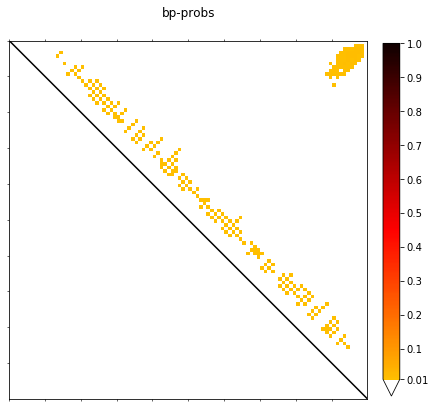

In [20]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-mergedoverlap-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta')
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/stau-mergedoverlap-Galaxy1-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)


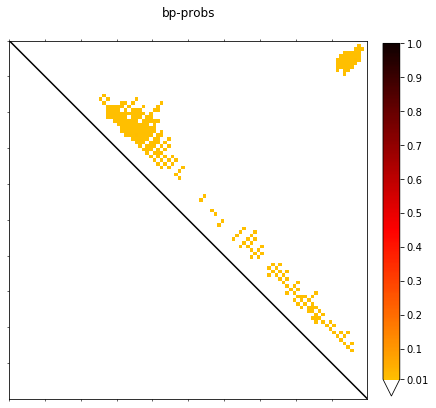

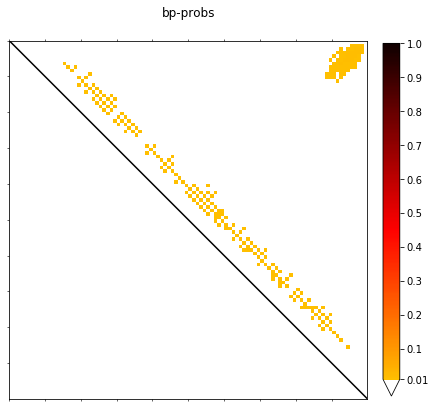

In [21]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Staufen-ALL11k-Galaxy8-[Extract_Genomic_DNA_on_data_3_and_data_7].fasta')
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Staufen-ALL11k-Galaxy8-[Extract_Genomic_DNA_on_data_3_and_data_7].fasta',shuffle=True)


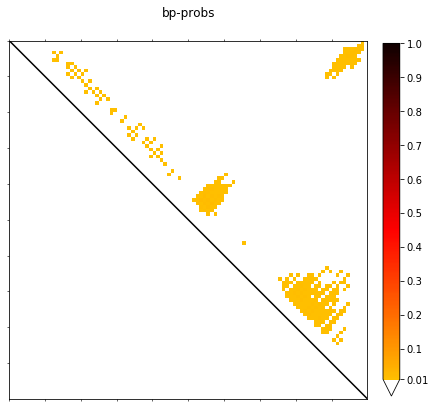

In [22]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Stau-merged-peakcentered-Galaxy2-[Extract_Genomic_DNA_on_data_1].fasta')


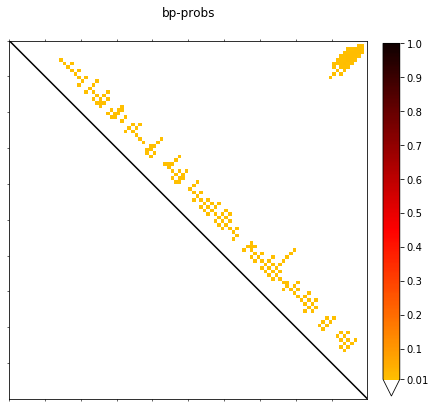

In [23]:
analyze_average_dps('/home/milad/1workspace/GalaxyGraphClust/Staufen/commonfold/Stau-merged-peakcentered-Galaxy2-[Extract_Genomic_DNA_on_data_1].fasta',shuffle=True)


In [83]:
from altschulEriksonDinuclShuffle import dinuclShuffle
dinuclShuffle('CCTGACGTCAGCAGACCGAGACCAGTCCCAGTTCCAGGGGGAGGCCTGCAGGCCCCTGGCCCCTTCCACCACCTCTGCCCTCCGTCTGCAGACCTCGTCC'.replace('T','U'))

'CCGCGGAGCCUCCAGGCACCAGUGGGUCCACUUGUGUGCAGAGACCCCACUGGCCCCCCCCUCUUCCCCAGAGGUCUCUCCAGCAGACUCCGGACUCCGC'

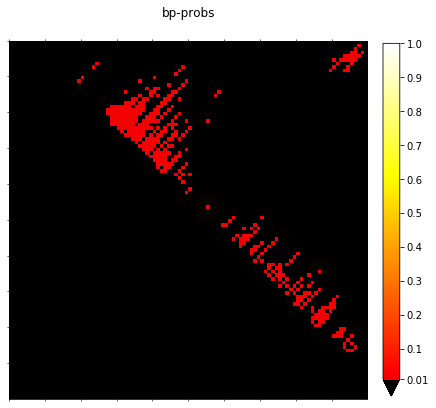

In [49]:
plot_heat_maps(None, average_basepair_prob_seqs(read_seqs[:]), filename='/tmp/test.heatmap', what='basepairs',
                   inverse=False, interactive=False, gene_loc=None)


In [45]:
read_seqs[:10]

['ACCCCTTTCCACCTTTTGTATTTAATTTTAAAGTCAGTGTACTGCAAGGAAGCTGGATGCAAGATAGATACTATATTAAACTGTACTGTTATTTAAGATG',
 'TCTATACAAAACTGTGCTGTGACCTTGCGGTAGGCCTGGATCTGGCAAAGAGAATACAAATGAAACCCCTTCTTTCTCTTTCCGTCCAACAACTCTGTAG',
 'TTTTAATCTCACTTTGGGTTTCCTTGTGAAGTTGGAGGGAAGTTTATAATAGCCTAACACTACCCCACCCCCAACTAGGAGGAACCTCTGTTTTCAAGAG',
 'ATTCCAACTTGGACGCGTTACCATGAGAGCATATCCTATCCAACCGTACTAACGTGGACACCCTACACCTCCCCTCAGAACTTCAAAAGGGCAAGATCTT',
 'TTTTCAGCGACAAGGACCCAGGTCTTCCTGCTGCTGCCAGGGAGAGCAGGGACAGTGCCGCGTGCGAGATGAGCTCGAACACTGCCCGCCTTACTGCCGC',
 'TCTTTGCGGTTGTTCTGTGTGCATGGATTCCACACCTCTGCCGTAGGTAGATCCGTCAGCGGGCATTATTACCGTGTCTTGTAAAGGGTCGGTTTTGTTA',
 'TTTTAACGAAGGGAAAAACAACAGCAATAACATTCATATCTCTGGAGCAGCTAACTCATACACGTAATGTCTGCTTTTCGTACAGAACTAGCCAATGTAA',
 'CGTTCTCGCTTTAAGTCAGGAGTCACAAATGACTTTTTTTTTTCAATTAAGGAAAAAGCTCCATCTCTACCTTTAACATCACCCAGACCCCCGCCCCTGC',
 'ttatCCCTTTAATTAAAGGGAGCAAAGGGGCGTTCCACATGGACAGAGGCTTGGACCGAGGCCTGGTCACAGCAGCGAGCATCCAGGGTTTGCAGGGACG',
 'TTTCCTTGATTTCTCAGTAGGTGCTAGAATCCAGTTCACACCCTTCACTGTGC